# Exploring the idea of a Double-Wilson distribution

The structure factors of related structures are likely to be strongly correlated. We should be able to exploit this correlation during scaling and merging by constraining the optimization more strongly than by the requirement that structure factors following a Wilson distribution. 

The Wilson distribution derives from a model where each structure factor derives from a 1D (centric) or 2D (acentric) random walk on the real axis or the complex plane, as appropriate. The amplitudes thereof follow the Wilson distributions. A natural extension would be for the corresponding structure factors of two data sets to perform correlated random walks, resulting in a joint multivariate normal distribution of the real and complex components of the (complex) structure factors of the two data sets.

We will use pairs of similar datasets to explore this idea in steps. The section numbers apply if you have a TOC enabled (they're static, so they may be outdated).
* (1.2)   Loading data and combining them into a single frame.
* (1.3)   Scaling to each other and normalizing data sets using an anisotropic scale model.
* (1.4)   Normalizing structure factors using "Kernel ridge regression" or "k-nearest neighbor regression" to estimate Sigma, the mean reflection intensity within different parts of the reciprocal lattice.
* (1.5.1) Exploring the properties of the Double-Wilson distribution for fake data drawn from the distribution.
* (1.5.2) Calibrating the model to observed correlations for the real data
* (1.5.3) Analysis of the real data

A key point revealed by the analysis is that the parameter $r_{DW}$ used in the Double-Wilson model is a function of resolution and seems to be well described by the Luzzati model on p. 903 in Read (1990), "Structure-Factor Probabilities for Related Structures". 

**PS**: Read's paper is focused on correlations between Fc's rather than Fobs's, its entire analytical apparatus carries over to our case with 

- $r_{DW} = \textbf{D}$ (or $\sigma_E$ in eqs. 28-30).
- his $\textbf{s}$ equal to the reciprocal lattice point vector which I calculate below as (rs_a, rs_b, rs_c).
- his $\sigma^2_{\Delta}$ related to our conditional variance $\frac{1}{2}(1-r_{DW}^2)$.

**Notation**
- we will use $hkl$ and ```HKL```
- we will denote reciprocal lattice point coordinates as ```(rs_a,rs_b,rs_c)``` and $r*$, with magnitude $1/d_{hkl}$ or ```dHKL```. The scattering vector $s=S_1-S_0$ equals $r*$ in our case (elastic scattering).

**Possible improvements**
* Kevin suggests using the Wilson distributions themselves as the loss functions in kernel ridge regression. This can't be implemented in Sci-kit learn, but could be in keras/Tensorflow

## Getting started

In [1]:
%autosave 300
# !cat /proc/meminfo | grep Mem

Autosaving every 300 seconds


### Imports

In [2]:
# General tools
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy   as np
import pandas  as pd
import copy
import time
import pickle
from mpl_toolkits import mplot3d
from tqdm         import tqdm
from os           import path as os_path

sns.set_context("notebook", font_scale=1.3)


Bad key "text.kerning_factor" on line 4 in
C:\Users\Doeke Hekstra\.conda\envs\crystallography\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
import reciprocalspaceship as rs
import gemmi
from sklearn.model_selection import train_test_split
from sklearn.metrics         import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors       import KNeighborsRegressor
from scipy.optimize          import least_squares, minimize
from scipy.stats             import rice, foldnorm, vonmises, linregress, pearsonr

In [4]:
rs.__version__

'0.9.3'

### Reading in data sets

Note: I will use ```ds``` as a generic dummy for a dataset used locally when that simplifies notation, e.g. in functions.

In [5]:
path="double_wilson_data/"    # Unix
ds1=rs.read_mtz(path + "NECAT_HEWL_RT_NaI_82_XDS_scaled1.mtz")
ds1.info()

ds1["I(-)"]=np.maximum(0.01,ds1["I(-)"].to_numpy())
ds1["I(+)"]=np.maximum(0.01,ds1["I(+)"].to_numpy())
ds1["FP_1"]=np.sqrt( ds1["I(-)"])
ds1["FP_2"]=np.sqrt( ds1["I(+)"])
ds1["SIGFP_1"] = 0.5*(ds1["SIGI(-)"]+0.01)/(ds1["FP_1"]+0.01)
ds1["SIGFP_2"] = 0.5*(ds1["SIGI(+)"]+0.01)/(ds1["FP_2"]+0.01)
ds1=ds1.dropna()  
ds1.info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 33298 entries, (0, 0, 4) to (63, 2, 1)
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype           
---  ------      --------------  -----           
 0   FreeR_flag  33298 non-null  MTZInt          
 1   IMEAN       33281 non-null  Intensity       
 2   SIGIMEAN    33281 non-null  Stddev          
 3   I(+)        33281 non-null  FriedelIntensity
 4   SIGI(+)     33281 non-null  StddevFriedelI  
 5   I(-)        33281 non-null  FriedelIntensity
 6   SIGI(-)     33281 non-null  StddevFriedelI  
 7   N(+)        33281 non-null  MTZInt          
 8   N(-)        33281 non-null  MTZInt          
dtypes: FriedelIntensity(2), Intensity(1), MTZInt(3), Stddev(1), StddevFriedelI(2)
memory usage: 2.1 MB
<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 33281 entries, (0, 0, 4) to (63, 2, 1)
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  ----- 

### Combining data sets

#### Adding reciprocal lattice point coordinates
Let's calculate the reciprocal lattice point coordinates for each reflection.

In [6]:
def ds_add_rs(ds,force_rs=False,inplace=True):
    """
    Adds three columns to an rs dataframe with the reciprocal space coordinates (in A^-1) for each Miller index.
    Inplace by default!
    """
    if force_rs or (not "rs_a" in ds.keys()):
        orthomat_list  = ds.cell.orthogonalization_matrix.tolist()
        orthomat = np.asarray(orthomat_list)
    
        hkl_array = np.asarray(list(ds.index.to_numpy()))
    
        orthomat_inv_t = np.linalg.inv(orthomat).transpose()
        S = np.matmul(orthomat_inv_t, hkl_array.transpose())
        
        if inplace==True:
            ds["rs_a"]=S.transpose()[:,0]
            ds["rs_b"]=S.transpose()[:,1]
            ds["rs_c"]=S.transpose()[:,2]
        else:
            ds_out=ds.copy()
            ds_out["rs_a"]=S.transpose()[:,0]
            ds_out["rs_b"]=S.transpose()[:,1]
            ds_out["rs_c"]=S.transpose()[:,2]
    else:
        if inplace==True:
            pass
        else:
            ds_out=ds.copy()
            ds_out["rs_a"] = ds["rs_a"]
            ds_out["rs_b"] = ds["rs_b"]
            ds_out["rs_c"] = ds["rs_c"]
    if inplace==True:
        return # already done
    else:
        return ds_out

In [7]:
ds_add_rs(ds1)
# ds_test = ds_add_rs(ds2,inplace=False)

#### Combining data sets in a joint data frame
Let's combine ("merge" in pandas jargon) the data frames of the two datasets. We'll add the ratios of the observed structure factor amplitudes as columns and a few other columns that will come in handy. 
Towards the end of the notebook, we clean up all datatypes. 

In [8]:
# ds1_2= ds1.merge(ds2, left_index=True, right_index=True, suffixes=("_1", "_2"))

# # Let's add some extra columns with useful info
ds1_2 = ds1
ds1_2["gamma_pp"] = ds1_2["FP_2"]/ds1_2["FP_1"]
ds1_2.compute_dHKL(        inplace=True)
ds1_2.label_centrics(      inplace=True)
ds1_2.compute_multiplicity(inplace=True)
ds1_2.info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 33281 entries, (0, 0, 4) to (63, 2, 1)
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   FreeR_flag  33281 non-null  MTZInt        
 1   IMEAN       33281 non-null  Intensity     
 2   SIGIMEAN    33281 non-null  Stddev        
 3   I(+)        33281 non-null  float32       
 4   SIGI(+)     33281 non-null  StddevFriedelI
 5   I(-)        33281 non-null  float32       
 6   SIGI(-)     33281 non-null  StddevFriedelI
 7   N(+)        33281 non-null  MTZInt        
 8   N(-)        33281 non-null  MTZInt        
 9   FP_1        33281 non-null  float32       
 10  FP_2        33281 non-null  float32       
 11  SIGFP_1     33281 non-null  StddevFriedelI
 12  SIGFP_2     33281 non-null  StddevFriedelI
 13  rs_a        33281 non-null  float64       
 14  rs_b        33281 non-null  float64       
 15  rs_c        33281 non-null  float64       
 16  g

We'll check our reciprocal lattice coordinates by checking their norm matches $1/d_{HKL}$.

False


C:\Users\Doeke Hekstra\.conda\envs\crystallography\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Doeke Hekstra\.conda\envs\crystallography\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


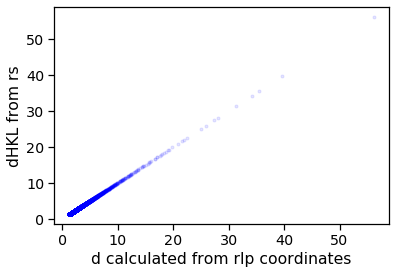

In [9]:
tmp=np.sqrt(1/(ds1_2["rs_a"]**2 +ds1_2["rs_b"]**2 +ds1_2["rs_c"]**2))
print((tmp==0).any())

plt.plot(np.sqrt(1/(ds1_2["rs_a"]**2 +ds1_2["rs_b"]**2 +ds1_2["rs_c"]**2)), ds1_2["dHKL"],'b.',alpha=0.1)
plt.xlabel('d calculated from rlp coordinates'), plt.ylabel('dHKL from rs')
plt.show()

#### Checking reciprocal space (ASU) coverage
Let's see what chunk of reciprocal space these reflections are located in. I can't recall how I got this figure to be interactive.

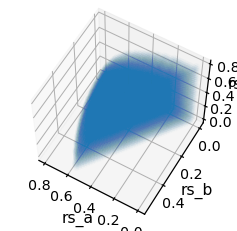

In [10]:
# uses "from mpl_toolkits import mplot3d"
plt.ion
fig = plt.figure(figsize=(4,4))
ax = plt.axes(projection="3d")
ax.scatter3D(ds1["rs_a"], ds1["rs_b"], ds1["rs_c"],alpha=0.01)
ax.view_init(elev=60., azim=1200.)
ax.set_xlabel("rs_a")
ax.set_ylabel("rs_b")
ax.set_zlabel("rs_c")
plt.draw()

#for angle in range(0, 360):
#    ax.view_init(30, angle)
#    plt.draw()
#    plt.pause(.001)

## Anisotropic scaling

Let's start by setting a training set and test set. Because of the way the loss function below is constructed, we can just pass on entire data frames.

In [11]:
# uses "from sklearn.model_selection import train_test_split"
# the split may not be currently relevant.
X_train, X_test, y_train, y_test = train_test_split(ds1_2, ds1_2, test_size=0.3, random_state=42)

### Loss functions
We'll define two "loss functions" or "objective functions" which we'll minimize in order to 
1. anisotropically scale one data set to another, or 
2. optimally predict average structure factor amplitude from (hkl) in the form of the reciprocal lattice point coordinates. 

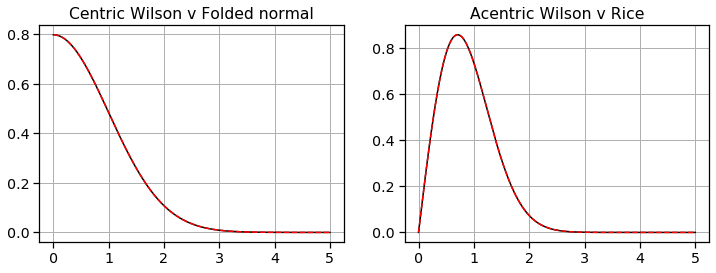

<ipython-input-12-6ecb6f15988f>:41: RuntimeWarning: divide by zero encountered in log
  plt.plot(x,np.log(pe1),'k-')
C:\Users\Doeke Hekstra\.conda\envs\crystallography\lib\site-packages\scipy\stats\_distn_infrastructure.py:1722: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


Text(0.5, 1.0, 'Acentric Wilson v Rice')

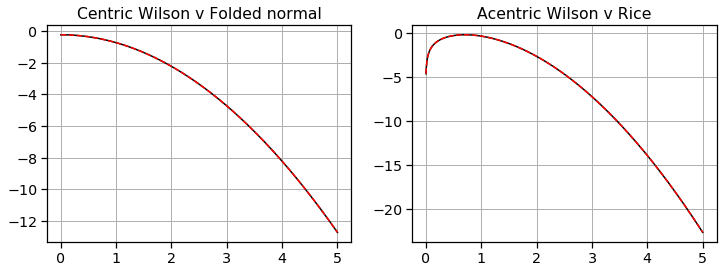

In [12]:
def wilson_dist_normalized(E, centric=False, nargout=1):
    if centric:
        P_E = np.sqrt(2/np.pi)*np.exp(-0.5*E**2)  # Rupp eq. 7-111
        P_E2 = foldnorm.pdf(E,0,0,1)
    else:
        P_E = 2*E*np.exp(-E**2)                   # Rupp eq. 7-112
        P_E2 = rice.pdf(E,0,0,np.sqrt(0.5))
    if nargout==1:
        return P_E
    else:
        return P_E, P_E2

x=np.linspace(0,5,1000)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
pe1,pe2=wilson_dist_normalized(x,centric=True,nargout=2)
plt.plot(x,pe1,'k-')
plt.plot(x,pe2,'r--')
plt.grid()
plt.title("Centric Wilson v Folded normal")

plt.subplot(1,2,2)
pe1,pe2=wilson_dist_normalized(x,centric=False,nargout=2)
plt.plot(x,pe1,'k-')
plt.plot(x,pe2,'r--')
plt.grid()
plt.title("Acentric Wilson v Rice")
plt.show()

x=np.linspace(0,5,1000)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
pe1,pe2=wilson_dist_normalized(x,centric=True,nargout=2)
plt.plot(x,np.log(pe1),'k-')
plt.plot(x,foldnorm.logpdf(x,0,0,1),'r--')
plt.grid()
plt.title("Centric Wilson v Folded normal")

plt.subplot(1,2,2)
pe1,pe2=wilson_dist_normalized(x,centric=False,nargout=2)
plt.plot(x,np.log(pe1),'k-')
plt.plot(x,rice.logpdf(x,0,0,np.sqrt(0.5)),'r--')
plt.grid()
plt.title("Acentric Wilson v Rice")


In [13]:
def anisotropic_scaling_train_model(p, ds_a, ds_b,nargout=1):
    """
    Anisotropically scales one set of structure factor amplitudes to another (presumably one 
    can do this for intensities too). 
    
    Assumes rs dataframes obtained from merging two data sets (in the pandas sense),
    the first one with keys FP_1, SIGFP_1, rs_a_1, rs_b_1, rs_c_1; 
    the second with keys FP_2, SIGFP_2.
    The first one is scaled to the second one with input parameters p such that 
    B = [[p0, p1, p2], [p1, p3, p4], [p2, p4, p5]]. The two dataframes can be the same.
    
    Returns an error-weighted residual.
    """
    
    rlp      = ds_a[["rs_a", "rs_b", "rs_c"]].to_numpy()
    
    B        = np.asarray([[p[0],p[1],p[2]],[p[1],p[3],p[4]],[p[2],p[4],p[5]]])
    B_corr   = np.exp(-np.sum(rlp * (B @ rlp.transpose()).transpose(),axis=1)).reshape(-1,1)
    
    FP_corr  = np.abs(p[6])*B_corr * ds_a["FP_1"].to_numpy().reshape(-1,1)
    residual = ds_b["FP_2"].to_numpy().reshape(-1,1) - FP_corr
    #print(FP_corr)
    
    err_a = ds_a["SIGFP_1"].to_numpy()
    err_b = ds_b["SIGFP_2"].to_numpy()
    quad_error = np.sqrt(err_a**2 + err_b**2)
    residual = residual/quad_error.reshape(-1,1)
    
    if nargout == 1:
        return residual.flatten()
    else:
        return residual.flatten(), FP_corr, B_corr

def anisotropic_scaling_to_1(p, ds, label="FP_1", mode="F", nargout=1):
    """
    Scales a dataset with keys FP_1, SIGFP_1, to optimally fit F = a * exp(-r*T B r*))*sqrt(eps), 
    with r* the reciprocal lattice vectors, encoded as rs_a_1, rs_b_1, rs_c_1, 
    epsilon the multiplicity, and {a * exp(-r*T B r*))} playing the role of 1/sqrt(Sigma).
    Residuals are weighted by SIGFP, which may not be so appropriate...    
    
    Input arguments:
        p :       list or vector with parameters such that B = [[p0, p1, p2], [p1, p3, p4], [p2, p4, p5]] 
                   and p[6] is a scalar prefactor for structure factor amplitudes
        ds:       data frame with, at least, columns "rs_a_1", "rs_b_1", "rs_c_1", "EPSILON"
        label:    column label for structure factor amplitdes to be scaled. default: "FP_1".
                   a column with label {"SIG" + label} should also exist.
        mode :    mode="F" (default) will scale structure factor amplitudes to have amean of 1; "I" will do so for 
                  intensities, accounting for multiplicity.
        nargouts: determines whether to only output residuals (1) or all return values (>1)
        
    Returns:
        residual: an error-weighted residual
        EP_corr:  scaled structure factor amplitudes
        err_EP:   error of EP_corr
    """
    
    rlp      = ds[["rs_a", "rs_b", "rs_c"]].to_numpy()
    
    B        = np.asarray([[p[0],p[1],p[2]],[p[1],p[3],p[4]],[p[2],p[4],p[5]]])
    B_corr   = np.exp(-np.sum(rlp * (B @ rlp.transpose()).transpose(),axis=1))
    F        = ds[label].to_numpy()
    total_scale = np.abs(p[6]) * B_corr / np.sqrt(ds["EPSILON"].to_numpy())
    EP_corr  = total_scale * F
    
    err_F = ds["SIG" + label].to_numpy()
    err_EP  = err_F * total_scale
    if mode=="F":
        if nargout > 1:
            print("mode: F")
        residual = (1.0 - EP_corr) # amplitudes scaled to 1 (not intensities, which would be more appropriate)
        residual = residual/err_EP
    else: #assume normalize as intensities
        if nargout > 1:
            print("mode: I")
        residual = (1.0 - EP_corr**2) # amplitudes scaled to 1 (not intensities, which would be more appropriate)
        err_I    = 2 * F * err_F      # error propagation
        err_EP2  = err_I * total_scale**2
        residual = residual/err_EP2
        
    if nargout == 1:
        return residual
    else:
        return residual, EP_corr, err_EP
    
def anisotropic_scaling_to_1_wilson_loss(p, ds, label="FP_1", nargout=1):
    """
    Scales a dataset with keys FP_1, SIGFP_1, to optimally fit F = a * exp(-r*T B r*))*sqrt(eps), 
    with r* the reciprocal lattice vectors, encoded as rs_a_1, rs_b_1, rs_c_1, 
    epsilon the multiplicity, and {a * exp(-r*T B r*))} playing the role of 1/sqrt(Sigma)
    We'll assume that measurement error is irrelevant to observed spread.     
    
    Input arguments:
        p :       list or vector with parameters such that B = [[p0, p1, p2], [p1, p3, p4], [p2, p4, p5]] 
                   and p[6] is a scalar prefactor for structure factor amplitudes
        ds:       data frame with, at least, columns "rs_a_1", "rs_b_1", "rs_c_1", "EPSILON"
        label:    column label for structure factor amplitdes to be scaled. default: "FP_1".
                   a column with label {"SIG" + label} should also exist.
        nargouts: determines whether to only output residuals (1) or all return values (>1)
        
    Returns:
        loss:     loss function value
        EP_corr:  scaled structure factor amplitudes
        err_EP:   error of EP_corr
    """
    
    rlp      = ds[["rs_a", "rs_b", "rs_c"]].to_numpy()
    
    B        = np.asarray([[p[0],p[1],p[2]],[p[1],p[3],p[4]],[p[2],p[4],p[5]]])
    B_corr   = np.exp(-np.sum(rlp * (B @ rlp.transpose()).transpose(),axis=1))
    F        = ds[label].to_numpy()
    total_scale = np.exp(p[6]) * B_corr / np.sqrt(ds["EPSILON"].to_numpy())
    EP_corr  = total_scale * F
    err_F = ds["SIG" + label].to_numpy()
    err_EP  = err_F * total_scale

    EP_corr  = (EP_corr**4/(1+(EP_corr/20)**4))**0.25 # we need this nonlinearity to stop running out of the range 
                                            # where the loss functions have meaningfull probability
    loss_E_ac = -2*rice.logpdf(EP_corr, 0,0,np.sqrt(0.5))
    loss_E_c  = -2*foldnorm.logpdf(EP_corr, 0, 0, 1)

    loss = np.sum(loss_E_ac[ds["CENTRIC"]==False]) + np.sum(loss_E_c[ds["CENTRIC"]==True])
    
    if nargout == 1:
        return loss
    else:
        return loss, EP_corr, err_EP

(0, 20)

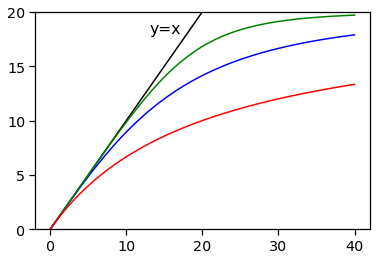

In [14]:
## we use the following soft upper limit above
x=np.linspace(0,40,1000)
plt.plot(x,x,'k-')
plt.plot(x,np.sqrt(x**2/(1+0.0025*x**2)),'b-')
plt.plot(x,(x**4/(1+(x/20)**4))**0.25,'g-')
plt.plot(x,x/(1+0.05*x),'r-')
plt.text(13,18,"y=x")
plt.ylim([0,20])

### Optimization: scaling data set 1 to data set 2
Next, we set up a robust nonlinear least-squares fit of the anisotropic model above to scale dataset 1 to dataset 2. That is, 
$F_1^{sc}= A e^{-r*^{T} B r*} F_1$, with $r*$ the reciprocal lattice point coordinates which depend on $hkl$.

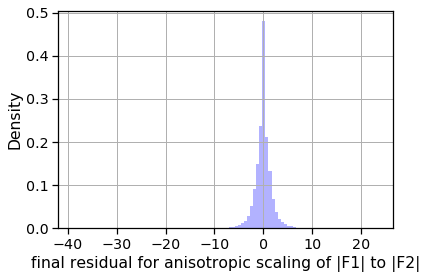

In [15]:
# from scipy.optimize import least_squares
res_robust   = least_squares(anisotropic_scaling_train_model, [0,0,0,0,0,0,0], loss='cauchy', f_scale=1, args=(X_train, y_train))

# with a round of outlier rejection:
#res_robust_2 = least_squares(anisotropic_scaling_model, res_robust.x,  loss='soft_l1', f_scale=1, 
#                             args=(X_train.loc[np.abs(res_robust.fun)<np.percentile(np.abs(res_robust.fun),98)], 
#                                   y_train.loc[np.abs(res_robust.fun)<np.percentile(np.abs(res_robust.fun),98)]))

plt.hist(res_robust.fun,100, alpha=0.3,color='b', density=True)
plt.grid()
plt.xlabel("final residual for anisotropic scaling of |F1| to |F2|")
plt.ylabel('Density')
plt.show()

Let's see how well ratios of |F_2|/|F_1| are explainted by the anisotropic scaling coefficients.

-0.018072797883531885
Slope: -9.898898997229857, intercept: 10.946543451691852


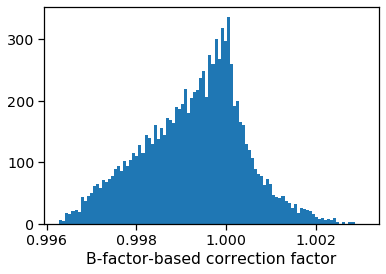

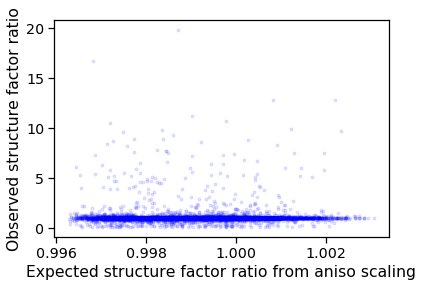

In [16]:
# from sklearn.metrics import r2_score
test,  ep_corr,  B_corr = anisotropic_scaling_train_model(res_robust.x, X_test, y_test, nargout=3)

slope, intercept, r_value, p_value, std_err = linregress(B_corr.flatten(), y_test["gamma_pp"].to_numpy())
print(r_value)
print("Slope: " + str(slope) + ", intercept: " + str(intercept))

plt.hist(B_corr,100)
plt.xlabel("B-factor-based correction factor")
plt.show()

plt.plot(B_corr, y_test["gamma_pp"].to_numpy(),'b.',alpha=0.1)
plt.xlabel('Expected structure factor ratio from aniso scaling')
plt.ylabel('Observed structure factor ratio')
# plt.ylim((0,plt.xlim()[1]))
plt.show()

For most examples, anisotropic scaling explains a significant part of the observed ratios of structure factor amplitudes. The **e35**  example is an exception.

### Adding scaled FP1 to the joint dataframe
Adding the anisotropically scaled FP_1 and SIGFP_1 to the joint dataframe.

In [17]:
test2, fp_corr2, B_corr2 = anisotropic_scaling_train_model(res_robust.x, ds1_2, ds1_2, nargout=3)
ds1_2["FP_1_scaled"] = fp_corr2.flatten()
ds1_2["SIGFP_1_scaled"] = B_corr2.flatten() * ds1_2["SIGFP_1"]
# ds1_2.info()

The effect of anisotropic scaling is usually clear graphically:

C:\Users\Doeke Hekstra\.conda\envs\crystallography\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


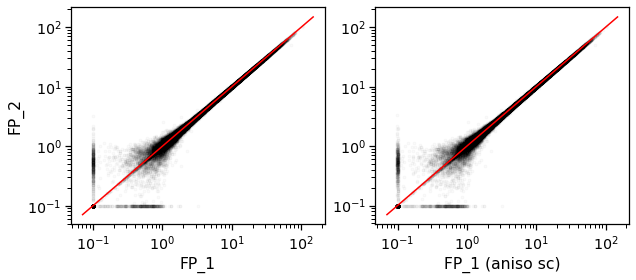

In [18]:
plt.figure(1,figsize=(10,4))
plt.subplot(1,2, 1)
plt.loglog(ds1_2["FP_1"], ds1_2["FP_2"],'k.',alpha=0.02)
plt.xlabel("FP_1"), plt.ylabel("FP_2")
plt.plot(plt.xlim(),plt.xlim(),'r-')

plt.subplot(1,2, 2)
plt.loglog(ds1_2["FP_1_scaled"], ds1_2["FP_2"],'k.',alpha=0.02)
plt.xlabel("FP_1 (aniso sc)")
plt.plot(plt.xlim(),plt.xlim(),'r-')

plt.show()

### Normalizing both datasets by anisotropic scaling
Let's scale both sets of structure factor amplitudes to have local mean of about 1. I initially used a least-squares regression with robust loss function for this, but have replaced this with a Wilson distribution loss.

In [19]:
# res_robust   = least_squares(anisotropic_scaling_to_1, [1,0,0,1,0,1,1], loss='soft_l1', f_scale=1, \
#                              args=(ds1_2,"FP_1","I",1)) #somehow can't keyword this

res = minimize(anisotropic_scaling_to_1_wilson_loss, [0,0,0,0,0,0,0],method='nelder-mead',args=(ds1_2,"FP_1"))

res_test, ep1, sigep1 = anisotropic_scaling_to_1_wilson_loss(res.x, ds1_2, label="FP_1", nargout=3)
ds1_2["EP_1_aniso"]   = ep1
ds1_2["SIGEP_1_aniso"]= sigep1
print("first one done...")

res = minimize(anisotropic_scaling_to_1_wilson_loss, [0,0,0,0,0,0,0],method='nelder-mead',args=(ds1_2,"FP_2"))
res_test, ep2, sigep2 = anisotropic_scaling_to_1_wilson_loss(res.x, ds1_2, label="FP_2",nargout=3)
ds1_2["EP_2_aniso"]   = ep2
ds1_2["SIGEP_2_aniso"]= sigep2

first one done...


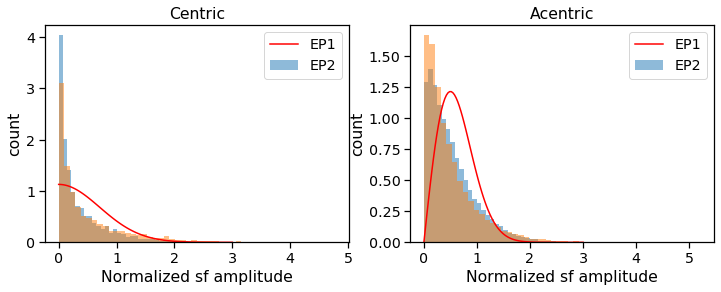

0.3383669808765585
0.638986321838556
0.48160595485936963
0.4777012072332093


In [20]:
x=np.linspace(0,3,100)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(ep1[ds1_2["CENTRIC"]==True],50,alpha=0.5,density=True)
plt.hist(ep2[ds1_2["CENTRIC"]==True],50,alpha=0.5,density=True)
plt.plot(x,np.sqrt(2)*wilson_dist_normalized(np.sqrt(2)*x,centric=True),'r-') # I am baffled by the need for the 
                                                                              # extra sqrt(2)'s
plt.legend(["EP1", "EP2"])
plt.ylabel("count")
plt.xlabel("Normalized sf amplitude")
plt.title("Centric")

plt.subplot(1,2,2)
plt.hist(ep1[ds1_2["CENTRIC"]==False],50,alpha=0.5,density=True)
plt.hist(ep2[ds1_2["CENTRIC"]==False],50,alpha=0.5,density=True)
plt.plot(x, np.sqrt(2)*wilson_dist_normalized(np.sqrt(2)*x,centric=False),'r-')
plt.legend(["EP1", "EP2"])
plt.ylabel("count")
plt.xlabel("Normalized sf amplitude")
plt.title("Acentric")
plt.show()

print(np.mean(ep1[ds1_2["CENTRIC"]==True]**2))
print(np.mean(ep2[ds1_2["CENTRIC"]==True]**2))
print(np.mean(ep1[ds1_2["CENTRIC"]==False]**2))
print(np.mean(ep2[ds1_2["CENTRIC"]==False]**2))

Use of a symmetric loss function obviously is not great for our purpose!  On another note, for the second example (2VWR, 5E1Y) there is a striking inconsistency between the two distributions.

#### Correlation coefficients with scaled and unscaled data

In [21]:
def compute_meanF_byres(ds, label="FP", nbins=20, sigma_cut=0, median=False):
    '''Calculate mean structure factor amplitude by res. bin.
    Use this function only for graphical inspection, not for scaling.
    '''
    #print(ds.shape)
    if sigma_cut > 0:
        incl_criteria = ds[label].to_numpy().flatten() > sigma_cut * ds["SIG" + label].to_numpy().flatten()
        ds2 = ds[incl_criteria].copy()
    else:
        ds2=ds.copy()
    
    ds2, bin_labels = ds2.assign_resolution_bins(bins=nbins)
    if median:
        print("Average observations per bin: " + str(ds2["bin"].value_counts().median()))
        result = ds2.groupby("bin")[label].median()
    else:
        print("Average observations per bin: " + str(ds2["bin"].value_counts().mean()))
        result = ds2.groupby("bin")[label].mean()
    return result, bin_labels


def compute_cc(ds, labels=["F1","F2"], nbins=20, method="spearman"):
    ds, bin_labels = ds.assign_resolution_bins(bins=nbins) #This adds a column to the input!
    print("Average observations per bin: " + str(ds["bin"].value_counts().mean()))
    g = ds.groupby("bin")[labels]
    result = g.corr(method=method).unstack().loc[:, (labels[0],labels[1])]
    return result, bin_labels


def plot_by_res_bin(result, bin_labels, ylabel=r"$CC_{1/2}$",color='b'):
    plt.plot(result, label="Data", color=color)
    plt.xticks(result.index, bin_labels, rotation=45, ha="right", rotation_mode="anchor")
    plt.ylabel(ylabel)
    plt.xlabel(r"Resolution Bin ($\AA$)")
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.ylim(0, )
    plt.grid(linestyle='--')
    #plt.tight_layout()
    #plt.show()
    return

Let's examine the average SF amplitude by resolution.

Average observations per bin: 1664.05
Average observations per bin: 1664.05
Average observations per bin: 1664.05


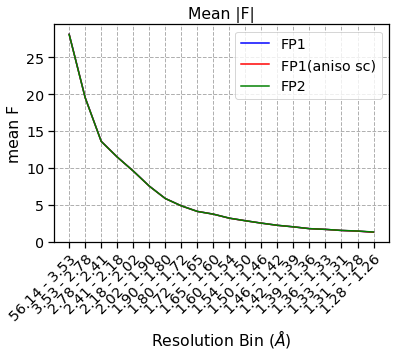

Average observations per bin: 1664.05
Average observations per bin: 1664.05


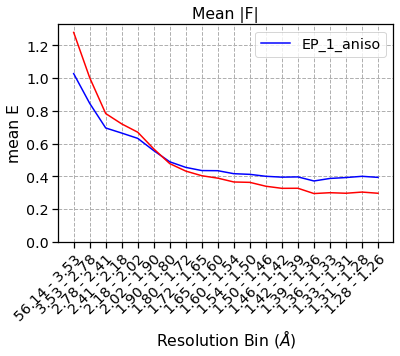

In [22]:
result, bin_labels = compute_meanF_byres(ds1_2, label="FP_1", nbins=20,sigma_cut=0)
plot_by_res_bin(result, bin_labels, ylabel="mean F",color='b')

result, bin_labels = compute_meanF_byres(ds1_2, label="FP_1_scaled", nbins=20,sigma_cut=0)
plot_by_res_bin(result, bin_labels, ylabel="mean F",color='r')

result, bin_labels = compute_meanF_byres(ds1_2, label="FP_2", nbins=20,sigma_cut=0)
plot_by_res_bin(result, bin_labels, ylabel="mean F",color='g')

plt.title("Mean |F|")
plt.legend(["FP1", "FP1(aniso sc)", "FP2"])
plt.ylim(0,)
plt.show()

result, bin_labels = compute_meanF_byres(ds1_2, label="EP_1_aniso", nbins=20,sigma_cut=0)
plot_by_res_bin(result, bin_labels, ylabel="mean E",color='b')
result, bin_labels = compute_meanF_byres(ds1_2, label="EP_2_aniso", nbins=20,sigma_cut=0)
plot_by_res_bin(result, bin_labels, ylabel="mean E",color='r')
plt.title("Mean |F|")
plt.legend(["EP_1_aniso"])
plt.ylim(0,)
plt.show()

Average observations per bin: 1664.05
Average observations per bin: 1664.05
Average observations per bin: 1664.05


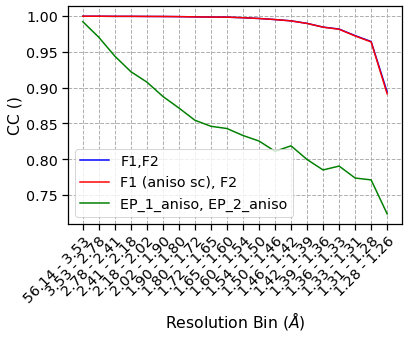

In [23]:
result_1, labels_1 = compute_cc(ds1_2,labels=["FP_1","FP_2"],nbins=20)
result_2, labels_2 = compute_cc(ds1_2,labels=["FP_1_scaled","FP_2"],nbins=20)
result_3, labels_3 = compute_cc(ds1_2,labels=["EP_1_aniso","EP_2_aniso"],nbins=20)
plot_by_res_bin(result_1, labels_1,)
plot_by_res_bin(result_2, labels_2,color='r')
plot_by_res_bin(result_3, labels_3,color='g')
plt.legend(["F1,F2","F1 (aniso sc), F2","EP_1_aniso, EP_2_aniso"])
# plt.ylim(0,1)
plt.ylabel("CC ()")
plt.show()

## Regression estimates of Sigma
We're estimating $<|F|^2>$ locally in reciprocal space! Because the expected intensity is the same for acentric and centric reflections, we can do this in one go for all of them.

By Rupp eq. (7-104): $ \Sigma_N = \left<I\right>/\varepsilon_h $

Below are two implementations of $\Sigma$ estimation: using kernel ridge regression and k-nearest neighbors with custom weights. The former retains more of the correlation among data sets than the latter, but is **much** slower and more memory-intensive. It crashes on the cluster.

In [24]:
temp = ds1_2["EPSILON"][ds1_2["CENTRIC"].to_numpy()==True]
print("Distribution of multiplicities for centric reflections:")
print(temp.value_counts())
print("")

temp = ds1_2["EPSILON"][ds1_2["CENTRIC"].to_numpy()==False]
print("Distribution of multiplicities for acentric reflections:")
print(temp.value_counts())


Distribution of multiplicities for centric reflections:
1    3960
2      75
4       7
Name: EPSILON, dtype: int64

Distribution of multiplicities for acentric reflections:
1    29239
Name: EPSILON, dtype: int64


Kernel ridge regression: see https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html
default loss function is the MSE. GridsearchCV performs, by default, 5-fold cross-validation for each set of parameters. Because of this, we use the full data set.

In [25]:
# perhaps it's worth making this a method.
def sigma_cut_ds(ds, F_col="FP", sigF_col="SIGFP", sigma_cut=3,inplace=False):
    if sigma_cut > 0:
        incl_criteria = ds[F_col].to_numpy().flatten() > sigma_cut * ds[sigF_col].to_numpy().flatten()
        ds2 = ds.loc[incl_criteria,:].copy()
    else:
        ds2=ds.copy()
    return ds2

Examine if we can use the results from a previous kernel ridge regression.

In [26]:
if os_path.exists(path + mtz1 + "_krr.pkl") & os_path.exists(path + mtz2 + "_krr.pkl"):
    print("Strongly consider skipping the next cell! It takes 30-60 min without crossvalidation")
    try:
        kr_1 = pickle.load(open(path + mtz1 + "_krr.pkl", 'rb'))
        kr_2 = pickle.load(open(path + mtz2 + "_krr.pkl", 'rb'))
    except:
        print("That didn't work")
else:
    print("No kernel ridge-regression has been performed yet!")

NameError: name 'mtz1' is not defined

### Kernel Ridge Regression implementation
The next cell takes up a ton of memory on the cluster. It runs slowly-but-fine on my laptop.
It's better to use the kNN version below instead.

In [ ]:
# from sklearn.model_selection import GridSearchCV
# #from sklearn.model_selection import learning_curve
# from sklearn.kernel_ridge import KernelRidge

# # consider adding pre-processing
# gridsearch = False # it takes up to an hour
# # this will take a few minutes:
# # GridsearchCV 
# #   1st try   (alpha=1,  gamma=100, kernel='rbf'), with alpha and gamma at the top of the initial ranges.
# #   2nd try   (alpha=10, gamma=100, kernel='rbf'), with alpha, but not gamma, at the top of the range
# #   3rd try   (alpha=30, gamma=100, kernel='rbf'), with alpha in [10,30,100], gamma fixed.
# # on 3rd try switched to neg_mean_absolute_error (from MSE)

# if gridsearch: # for regression hyperparameter optimization -- needs some tweaking
#     kr_1 = GridSearchCV(KernelRidge(kernel='rbf'), scoring='neg_mean_absolute_error',
#                       param_grid={"alpha": [300, 100, 30, 10],
#                                   "gamma": [300, 100, 30, 10]})
#     kr_1.fit(ds1_2[["rs_a_1", "rs_b_1", "rs_c_1"]], (ds1_2[["FP_1"]].to_numpy()**2)/ds1_2[["EPSILON"]].to_numpy())
#     kr_2 = GridSearchCV(KernelRidge(kernel='rbf'), scoring='neg_mean_absolute_error',
#                       param_grid={"alpha": [300, 100, 30, 10],
#                                   "gamma": [300, 100, 30, 10]})
#     kr_2.fit(ds1_2[["rs_a_2", "rs_b_2", "rs_c_2"]], (ds1_2[["FP_2"]].to_numpy()**2)/ds1_2[["EPSILON"]].to_numpy())
# else:
#     kr_1 = KernelRidge(kernel='rbf', alpha=30, gamma=100)
#     kr_2 = KernelRidge(kernel='rbf', alpha=30, gamma=100)
#     kr_1.fit(ds1_2[["rs_a_1", "rs_b_1", "rs_c_1"]], (ds1_2[["FP_1"]].to_numpy()**2)/ds1_2[["EPSILON"]].to_numpy())
#     kr_2.fit(ds1_2[["rs_a_2", "rs_b_2", "rs_c_2"]], (ds1_2[["FP_2"]].to_numpy()**2)/ds1_2[["EPSILON"]].to_numpy())

# pickle.dump(kr_1, open(path + mtz1 + "_krr.pkl",'wb'))
# pickle.dump(kr_2, open(path + mtz2 + "_krr.pkl",'wb'))

### k-nearest neighbor implementation to estimate Sigma
Here is a k-nearest-neighbor variant. We'll explore a few different kernels.

In [ ]:
# self-weights set to 0
def knn_weight_norm_p01(delta_r):
    r0 = 0.01 # inverse Angstrom
    return (delta_r>1e-8)*np.exp(-0.5*(delta_r/r0)**2)

def knn_weight_exp_p01(delta_r):
    r0 = 0.01 # inverse Angstrom
    return (delta_r>1e-8)*np.exp(-delta_r/r0)

def knn_weight_norm_p02(delta_r):
    r0 = 0.02 # inverse Angstrom
    return (delta_r>1e-8)*np.exp(-0.5*(delta_r/r0)**2)

def knn_weight_exp_p02(delta_r):
    r0 = 0.02 # inverse Angstrom
    return (delta_r>1e-8)*np.exp(-delta_r/r0)

def knn_weight_norm_p03(delta_r):
    r0 = 0.03 # inverse Angstrom
    return (delta_r>1e-8)*np.exp(-0.5*(delta_r/r0)**2)

def knn_weight_exp_p03(delta_r):
    r0 = 0.03 # inverse Angstrom
    return (delta_r>1e-8)*np.exp(-delta_r/r0)


The following cell is meant to help debug k-nearest neighbors. Oddly the code worked for the first example and fails on the second.

In [ ]:
# print("total NaN's or nulls in dataframe: " + str(ds1_2.isnull().sum().sum()))
# print("find rows with Infs:")
# print(ds1_2[(ds1_2==np.inf).any(axis=1)])
# print("find rows with large FP_1:")
# print(ds1_2.loc[ds1_2["FP_1"]>1e4,"FP_1"])
# print(ds1_2.loc[ds1_2["FP_2"]>1e4,"FP_2"])
# print(np.isfinite(ds1_2["FP_1"].to_numpy()).all())
# print(np.isfinite(ds1_2["FP_2"].to_numpy()).all())
# print((ds1_2["EPSILON"].to_numpy()>0).all())
# tmp=(ds1_2[["FP_2"]].to_numpy()**2)/(ds1_2[["EPSILON"]].to_numpy())
# np.sum(np.isnan(tmp))

I don't know why the following cell sometimes fails. A weird divide by zero error.

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.neighbors import KNeighborsRegressor

# consider adding pre-processing
# grid search takes a few minutes
gridsearch = True 
param_grid={"n_neighbors":[20,40,60,80,100],'weights':['uniform',knn_weight_exp_p01, knn_weight_norm_p01, \
                                                                 knn_weight_exp_p02, knn_weight_norm_p02, \
                                                                 knn_weight_exp_p03, knn_weight_norm_p03]}
if gridsearch: # for regression hyperparameter optimization -- needs some tweaking
    knn_1 = GridSearchCV(KNeighborsRegressor(n_jobs=8),param_grid=param_grid)
    knn_1.fit(ds1_2[["rs_a", "rs_b", "rs_c"]], (ds1_2["FP_1"]**2/ds1_2["EPSILON"]).to_numpy())
#     knn_1.fit(ds1_2[["rs_a_1", "rs_b_1", "rs_c_1"]].to_numpy(), (ds1_2["EP_1_aniso"]**2).to_numpy()) # these should be corrected for eps already
    knn_2 = GridSearchCV(KNeighborsRegressor(n_jobs=8), param_grid=param_grid)
    knn_2.fit(ds1_2[["rs_a", "rs_b", "rs_c"]], (ds1_2["FP_2"]**2/ds1_2["EPSILON"]).to_numpy())
#     knn_2.fit(ds1_2[["rs_a_1", "rs_b_1", "rs_c_1"]].to_numpy(), (ds1_2["EP_2_aniso"]**2).to_numpy())
else:
    knn_1 = KNeighborsRegressor(40, weights=knn_weight_p02,n_jobs=8)
    knn_1.fit(ds1_2[["rs_a_1", "rs_b_1", "rs_c_1"]], (ds1_2[["FP_1"]].to_numpy()**2)/ds1_2[["EPSILON"]].to_numpy())
    knn_2 = KNeighborsRegressor(40, weights=knn_weight_p02,n_jobs=8)
    knn_2.fit(ds1_2[["rs_a_2", "rs_b_2", "rs_c_2"]], (ds1_2[["FP_2"]].to_numpy()**2)/ds1_2[["EPSILON"]].to_numpy())

# pickle.dump(knn_1, open(path + mtz1 + "_knn.pkl",'wb'))
# pickle.dump(knn_2, open(path + mtz2 + "_knn.pkl",'wb'))

In [ ]:
if gridsearch:
    print(knn_1.best_params_)
    print(knn_2.best_params_)

### Calculate normalized structure factors
Note: we've estimated $\Sigma$. To get normalized structure factors, $E_h=\frac{F_h}{\sqrt{\varepsilon \Sigma_h}}$, we need to do the following:

In [ ]:
# If using kernel ridge regression...
# Sigma_kr_1 = kr_1.predict(ds1_2[["rs_a_1", "rs_b_1", "rs_c_1"]])
# Sigma_kr_2 = kr_2.predict(ds1_2[["rs_a_2", "rs_b_2", "rs_c_2"]])

In [ ]:
Sigma_1 = knn_1.predict(ds1_2[["rs_a", "rs_b", "rs_c"]])
Sigma_2 = knn_2.predict(ds1_2[["rs_a", "rs_b", "rs_c"]])

In [ ]:
E1    = ds1_2["FP_1"   ].to_numpy()/np.sqrt(Sigma_1 * ds1_2["EPSILON"].to_numpy())
E2    = ds1_2["FP_2"   ].to_numpy()/np.sqrt(Sigma_2 * ds1_2["EPSILON"].to_numpy())
SIGE1 = ds1_2["SIGFP_1"].to_numpy()/np.sqrt(Sigma_1 * ds1_2["EPSILON"].to_numpy())
SIGE2 = ds1_2["SIGFP_2"].to_numpy()/np.sqrt(Sigma_2 * ds1_2["EPSILON"].to_numpy())

ds1_2["EP_1"]    = E1
ds1_2["EP_2"]    = E2
ds1_2["SIGEP_1"] = SIGE1
ds1_2["SIGEP_2"] = SIGE2

Let's see what, if anything, happened to the correlations per resolution shell (we see that kNN is a little worse than kernel ridge regression)

In [ ]:
result_1, labels_1 = compute_cc(ds1_2,labels=["FP_1","FP_2"],nbins=20)
result_2, labels_2 = compute_cc(ds1_2,labels=["FP_1_scaled","FP_2"],nbins=20)
result_3, labels_3 = compute_cc(ds1_2,labels=["EP_1","EP_2"],nbins=20)
plot_by_res_bin(result_1, labels_1)
plot_by_res_bin(result_2, labels_2,color='r')
plot_by_res_bin(result_3, labels_3,color='g')
plt.ylabel("CC between datasets (Spearman)")
plt.legend(["FP1-FP2", "FP1(sc)-FP2", "EP1-EP2"])
# plt.ylim(0,1)
plt.show()

Normalization condenses the range of the structure factor amplitudes quite a bit.

In [ ]:
plt.figure(1,figsize=(10,4))
plt.subplot(1,2, 1)
plt.loglog(ds1_2["FP_1"], ds1_2["FP_2"],'k.',alpha=0.02)
plt.xlabel("FP_1"), plt.ylabel("FP_2")
xl=plt.xlim()
plt.ylim(xl)
plt.plot(xl,xl,'r-')

plt.subplot(1,2, 2)
plt.loglog(ds1_2["EP_1"], ds1_2["EP_2"],'k.',alpha=0.01)
plt.xlabel("EP_1")
xl2=plt.xlim()
plt.plot(xl2,xl2,'r-')
plt.xlim((xl2[0],xl2[0]*xl[1]/xl[0])) # force to have the same range as the left panel
plt.ylim((xl2[0],xl2[0]*xl[1]/xl[0])) # force to have the same range as the left panel
plt.show()

Let's see how well the structure factor amplitudes fit the Wilson distributions.

In [ ]:
bins=np.linspace(0,5,50)

xl=(0,5)
plt.figure(1,figsize=(10,10))
plt.subplot(2,2, 1)
plt.hist(ds1_2["EP_1"][ds1_2["CENTRIC"].to_numpy()==False],bins=bins,density=True)
plt.plot(bins, wilson_dist_normalized(bins, centric=False),'r-')
plt.title("Distribution of acentric E")
plt.xlabel("E")
plt.xlim(xl)

plt.subplot(2,2, 2)
plt.hist(ds1_2["EP_1"][ds1_2["CENTRIC"].to_numpy()==True],bins=bins,density=True)
plt.plot(bins, wilson_dist_normalized(bins, centric=True),'r-')
plt.title("Distribution of centric E")
plt.xlabel("E")
plt.legend(["Expected","Observed"])
plt.xlim(xl)

plt.subplot(2,2, 3)
plt.hist(ds1_2["EP_2"][ds1_2["CENTRIC"].to_numpy()==False],bins=bins,density=True)
plt.plot(bins, wilson_dist_normalized(bins, centric=False),'r-')
plt.title("Distribution of acentric E")
plt.xlabel("E")
plt.xlim(xl)

plt.subplot(2,2, 4)
plt.hist(ds1_2["EP_2"][ds1_2["CENTRIC"].to_numpy()==True],bins=bins,density=True)
plt.plot(bins, wilson_dist_normalized(bins, centric=True),'r-')
plt.title("Distribution of centric E")
plt.xlabel("E")
plt.legend(["Expected","Observed"])
plt.xlim(xl)

plt.show()

Interpretation: The deviations at low E seem to be attributable to weak reflections tending to be systematically excluded from the data and/or an artefact from French-Wilson scaling inflating reflections. We calculate completeness at the end of this notebook, but it does not seem to be a major explanation.

## Conditional PDFs for normalized structure factors

### Benchmarks using synthetic data
We'll first examine some synthetic data generated from the Double-Wilson distribution and study their properties.

#### Mapping from double-wilson $r$ to Pearson corr for $|E|$
We start by making sure we understand the mapping between the parameter $r$ in the Double-Wilson distribution and the actual correlation coefficient between pairs of structure factor amplitudes.

In [ ]:
nsamples= 500000
nbin_r  = 20
r       = np.linspace(0,1,nbin_r)   # correlation between random walks 
mean    = [0,0,0,0]                 # mean of random walks

corr_r_ac = np.zeros([nbin_r,1])    # correlation between |F_1| and |F_2| samples from DW (acentric)
for i in tqdm(range(nbin_r)):
    cov     = 0.5*np.asarray([[1,0,r[i],0],[0,1,0,r[i]],[r[i],0,1,0],[0,r[i],0,1]])
    E_1x_1y_2x_2y = np.random.multivariate_normal(mean=mean, cov=cov,size=nsamples)
    # fake data set (acentric)
    ep1_test = np.sqrt(E_1x_1y_2x_2y[:,0]**2 +E_1x_1y_2x_2y[:,1]**2 )
    ep2_test = np.sqrt(E_1x_1y_2x_2y[:,2]**2 +E_1x_1y_2x_2y[:,3]**2 )
    corr_r_ac[i] = pearsonr(ep1_test, ep2_test)[0]

print("variance of sf acentric amplitudes from the DW distribution:" + \
     str(np.var(np.concatenate((ep1_test,ep2_test)))))
    
corr_r_c = np.zeros([nbin_r,1])
for i in tqdm(range(nbin_r)):
    cov     = 0.5*np.asarray([[1,0,r[i],0],[0,1,0,r[i]],[r[i],0,1,0],[0,r[i],0,1]])
    E_1x_1y_2x_2y = np.random.multivariate_normal(mean=mean, cov=cov,size=nsamples)
    # fake data set (centric)
    ep1_test = np.sqrt(E_1x_1y_2x_2y[:,0]**2 +E_1x_1y_2x_2y[:,0]**2 )
    ep2_test = np.sqrt(E_1x_1y_2x_2y[:,2]**2 +E_1x_1y_2x_2y[:,2]**2 )
    corr_r_c[i] = pearsonr(ep1_test, ep2_test)[0]

print("variance of sf acentric amplitudes from the DW distribution:" + \
     str(np.var(np.concatenate((ep1_test,ep2_test)))))

It is not _a priori_ obvious what the relationship between the parameter $r$ above and the correlation coefficient of the sf amplitudes should be. Below we'll see that $\rho(|F_1|,|F_2|)\approx r^2$. In the next two cells we look more carefully.

In [ ]:
from scipy.linalg import lstsq
M = r[:,np.newaxis]**[2,4,6,8]
beta_ac, res, rnk, s = lstsq(M,corr_r_ac)
beta_c,  res, rnk, s = lstsq(M,corr_r_c )

def r_dw_to_r_E(r,beta):
    X=np.array([r**2,r**4,r**6,r**8]).transpose()
    return np.dot(X,beta)

# despite this function, we'll use the square root as our proxy as it is trivial to invert.
# the coefficients of the least-square fit are quite variable, even with 500,000 samples.

print(beta_ac.transpose())
print(beta_c.transpose())

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)                       # Empirical and least-squares-fit mapping from r to pearson(E1,E2)
plt.plot(r,corr_r_ac,'bo-')              # ACENTRIC
plt.plot(r,r_dw_to_r_E(r,beta_ac),'m-')
plt.plot(r,r**2,'r--')
plt.legend(["observed","LSQ fit","simple r^2"])
plt.xlabel("DW parameter $r$")
plt.ylabel("Pearson $r$(E1,E2; acentric)")
plt.grid()

plt.subplot(1,2,2)                      # CENTRIC
plt.plot(r,corr_r_c,'bo-')
plt.plot(r,r_dw_to_r_E(r,beta_c),'m-')
plt.plot(r,r**2,'r--')
plt.legend(["observed","LSQ fit","simple r^2"])
plt.xlabel("DW parameter $r$")
plt.ylabel("Pearson $r$(E1,E2; centric)")
plt.grid()
plt.show()


# now the inverse
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)                       # Empirical and least-squares-fit mapping from r to pearson(E1,E2)
plt.plot(corr_r_ac,r,'bo-')              # ACENTRIC
plt.plot(corr_r_ac, np.sqrt(corr_r_ac+0.15*(corr_r_ac**2-corr_r_ac**3)),'m-')
plt.plot(corr_r_ac, np.sqrt(corr_r_ac),'r--')
plt.legend(["observed","manual fit","simple sqrt"])
plt.ylabel("DW parameter $r$")
plt.xlabel("Pearson $r$(E1,E2; acentric)")
plt.grid()

plt.subplot(1,2,2)                       # CENTRIC
plt.plot(corr_r_c,r,'bo-')
plt.plot(corr_r_c, np.sqrt(corr_r_c+0.3*(corr_r_c**2-corr_r_c**3)),'m-')
plt.plot(corr_r_c, np.sqrt(corr_r_c),'r--')
plt.legend(["observed","manual fit","simple sqrt"])
plt.ylabel("DW parameter $r$")
plt.xlabel("Pearson $r$(E1,E2; centric)")
plt.grid()
plt.show()

In good approximation, when a pair of normalized structure factors is drawn from an acentric double-wilson distribution, they have a correlation coefficient $r^2_{DW}$, with $r_{DW}$ parametrizing the DW distribution. This approximation is slightly worse for centric reflections.

#### FAKE DATA: generation & graphical inspection (acentric)

In [ ]:
nsamples= 100000
nbin    = 25
x       = np.linspace(0,5,100) # x-coordinates for plots
r_fake  = 0.9                  # correlation between random walks 
r       = r_fake
mean    = [0,0,0,0]            # mean of random walks
cov     = 0.5*np.asarray([[1,0,r,0],[0,1,0,r],[r,0,1,0],[0,r,0,1]])

E_1x_1y_2x_2y = np.random.multivariate_normal(mean=mean, cov=cov,size=nsamples)
print(E_1x_1y_2x_2y.shape)

# fake data set (acentric)
ds_test =         pd.DataFrame(np.sqrt(E_1x_1y_2x_2y[:,0]**2 +E_1x_1y_2x_2y[:,1]**2 ), columns = ["EP_1"])
ds_test["EP_2"] = pd.DataFrame(np.sqrt(E_1x_1y_2x_2y[:,2]**2 +E_1x_1y_2x_2y[:,3]**2 ))

# graphical inspection
plt.figure(figsize=(6,4))
plt.hist(ds_test["EP_1"].to_numpy(),100,density=True)
plt.plot(x, wilson_dist_normalized(x, centric=False),'r-')
plt.plot(x, rice.pdf(x,0,scale=np.sqrt(0.5)),'m--')
plt.legend(["Acentric Wilson", r"Rice($\nu=0$,$\sigma^2=\frac{1}{2}$) ", "Fake observed E (acentric)"])
plt.xlabel("Normalized structure factor amplitude")
plt.ylabel("Density")
plt.show()

#### FAKE DATA generation & graphical inspection (centric)
Now the same inspection for centric reflections. Note the subtle factor 2 resulting from multiplicity.

In [ ]:
# fake data set (centric)
# mind the sqrt(2)! we normalize, in effect, by the rms acentric amplitude
ds_test_cent = pd.DataFrame(        np.sqrt(2*E_1x_1y_2x_2y[:,0]**2), columns = ["EP_1"])
ds_test_cent["EP_2"] = pd.DataFrame(np.sqrt(2*E_1x_1y_2x_2y[:,2]**2))

print(ds_test_cent.mean())
# graphical inspection
plt.figure()
plt.hist(ds_test_cent["EP_2"].to_numpy(),100,density=True)
plt.plot(x, wilson_dist_normalized(x, centric=True),'r-')
plt.legend(["Centric Wilson", "Fake observed E (centric)"])
plt.xlabel("Normalized structure factor amplitude")
plt.ylabel("Density")
plt.show()

#### FAKE DATA: Conditional distribution for Acentrics. Step 1: means per bin for $|E_1|$.
We will calculate the conditional distributions of $|E_2|$ per bin of $|E_1|$. First, for **acentrics**.

In [ ]:
cdf_bins = np.linspace(0,100,nbin+1)
ep1_bins = np.percentile(ds_test["EP_1"], cdf_bins)
ep1_bins[-1] = ep1_bins[-1]+1e-6 # to avoid omitting the largest data point
ep1_dig  = np.digitize(ds_test["EP_1"], ep1_bins)
ds_test["EP_1_bin"] = ep1_dig.flatten()

unique, counts = np.unique(ds_test["EP_1_bin"], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin:")
print(temp)

bin_means=ds_test.groupby("EP_1_bin")["EP_1"].mean()
plt.plot(bin_means,'bo-')
plt.xlabel("Bin index")
plt.ylabel("Mean |E1| for bin")
plt.grid(True)
plt.ylim(0,)
plt.show()

#### FAKE DATA: Conditional distribution for Acentrics. Step 2: histograms of $|E_2|$ per bin of $|E_1|$.
The calculations of the parameters for the Rice distribution are not very intuitive. 

The conditional mean     $\mathbb{E}\left(E_2 | E_1\right) = r_{DW} E_1$ (centric and acentric; true for amplitudes and complex structure factors).

The conditional variance $\textrm{Var}\left(|E_2| | |E_1| \right) = \frac{1}{2}\left(1-r_{DW}^2\right)$ (acentric)
or                                                                           $\left(1-r_{DW}^2\right)$ (centric),
where the twice-as-large conditional variance for centrics is inherent in how they are calculated.

In [ ]:
plt.figure(figsize=(15,15))   # for illustration purposes use 15, 5
x=np.linspace(0,3,100)
counter = 0
for i in range(1,nbin+1):     # for illustration purposes use [1, 13, 25] 
    plt.subplot(5,5,i)
#    counter += 1             # for illustration purposes.
#    plt.subplot(1,3,counter) # for illustration purposes.
    rho = r_fake                   # see above
    r1 = rho*bin_means[i]     # conditional exp value
    cond_var = 0.5*(1-rho**2) # conditional var for acentrics
#    
    plt.hist(ds_test.loc[ds_test["EP_1_bin"]==i,"EP_2"],np.linspace(0,5,50),density=True)
    plt.plot(x, rice.pdf(x, r1/np.sqrt(cond_var),scale=np.sqrt(cond_var)),'r-')
    yl=plt.ylim()
#
#    to illustrate the idea of Rice interpolating between Wilson and delta function:
#    plt.plot(bin_means[i]*np.asarray([1, 1]),yl,'k-')
#    plt.plot(rice.mean(0,scale=1/np.sqrt(2))*np.asarray([1,1]),yl,'b-')
#    plt.plot(rice.mean(r1/np.sqrt(cond_var),scale=np.sqrt(cond_var))*np.asarray([1,1]),yl,'r:')
    xl=[0,3] #plt.xlim()
    plt.text(1.5,0.85*yl[1],f"<E1> = {bin_means[i]:.2f}",size=10)
    plt.xlim(xl)
 
plt.subplot(5,5,3)
plt.title("Conditional histograms (acentric, fake data)")
plt.show()
# Basic check:
#    plt.plot(np.sqrt((1-rho**2)+rho**2 * bin_means[i]**2), np.sqrt(np.mean(ds_test["EP_2"][ds_test["EP_1_bin"]==i]**2)), 'bo')

#### FAKE DATA: Conditional distribution for Centrics. Step 1: means per bin for $|E_1|$.

In [ ]:
cdf_cent_bins     = np.linspace(0,100,nbin+1)
ep1_cent_bins     = np.percentile(ds_test_cent["EP_1"], cdf_cent_bins)
ep1_cent_bins[-1] = ep1_cent_bins[-1]+1e-6 # to avoid omitting the largest data point
ep1_cent_dig  = np.digitize(ds_test_cent["EP_1"], ep1_cent_bins)
ds_test_cent["EP_1_bin"] = ep1_cent_dig.flatten()

unique, counts = np.unique(ds_test_cent["EP_1_bin"], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin:")
print(temp)

bin_means_cent=ds_test_cent.groupby("EP_1_bin")["EP_1"].mean()
plt.plot(bin_means_cent,'bo-')
plt.xlabel("Bin index")
plt.ylabel("Mean |E1| for bin")
plt.title("Centric")
plt.show()

#### FAKE DATA: Conditional distribution for Centrics. Step 2: histograms of $|E_2|$ per bin of $|E_1|$.

In [ ]:
plt.figure(figsize=(15,15))
x=np.linspace(0,3,100)
for i in range(1,nbin+1):
    #print(i)
    plt.subplot(5,5,i)
    rho = r_fake
    r1 = rho*bin_means_cent[i] # conditional exp value
    cond_var = (1-rho**2)      # no 0.5* for centrics!
    plt.hist(ds_test_cent["EP_2"][ds_test_cent["EP_1_bin"]==i],np.linspace(0,5,50),density=True)
    plt.plot(x, foldnorm.pdf(x, r1/np.sqrt(cond_var),scale=np.sqrt(cond_var)),'r-')
    xl=[0,3] #plt.xlim()
    #yl=plt.ylim()
    plt.xlim(xl)
    #plt.ylim(yl)
    #plt.xlabel("Expected conditional mean for parallel component")
    #plt.ylabel("Observed conditional mean for parallel component")

plt.subplot(5,5,3)
plt.title("Conditional histograms (Centric, fake data)")
plt.show()
# Basic check:
#    plt.plot(np.sqrt((1-rho**2)+rho**2 * bin_means[i]**2), np.sqrt(np.mean(ds_test["EP_2"][ds_test["EP_1_bin"]==i]**2)), 'bo')

### Expected correlation coefficients under experimental errors
Note: currently this redefines some variables from fake to real data.

In [ ]:
# Let's examine the distribution of dHKL and E in the real data
nbin=(20,10)

cdf_bins     = np.linspace(0,100,nbin[0]+1)
d_bins       = np.percentile(ds1_2["dHKL"], cdf_bins)
d_bins[-1]   = d_bins[-1]+1e-6   # to avoid omitting the largest data point
d_dig        = np.digitize(ds1_2["dHKL"], d_bins)
ds1_2["dHKL_bin_test"] = d_dig.flatten()
# print(d_bins)

cdf_bins     = np.linspace(0,100,nbin[1]+1)
ep1_bins     = np.percentile(ds1_2["EP_1"], cdf_bins)
ep1_bins[-1] = ep1_bins[-1]+1e-6 # to avoid omitting the largest data point
ep1_dig      = np.digitize(ds1_2["EP_1"], ep1_bins)
ds1_2["EP_1_bin_test"] = ep1_dig.flatten()


H, xedges, yedges = np.histogram2d(ds1_2["dHKL_bin_test"], ds1_2["EP_1_bin_test"],bins=nbin)
# print(H.shape)
# print(H)

plt.figure(figsize=(10,8))
im=plt.imshow(H.transpose(), interpolation='nearest', origin='lower',\
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmin=0)
plt.xlabel("resolution bin")
plt.ylabel("|E| bin")
plt.title("Counts per 2D bin for |E| and dHKL")
plt.colorbar(im,fraction=0.025, pad=0.04)
plt.show()

most columns of the above are fairly uniform, except we find that small-|E| reflections are depleted at high resolution. perhaps this is an artefact of French-Wilson scaling of very weak reflections at high resolution (small $d_{hkl}$).

To approximate the effect of measurement error on our fake data generated above, we'll resample the measurement errors of EP1 of our real data.

In [ ]:
# resample experimental standard deviations
count_max = 10*np.max(H[:]).astype(int)
print(count_max)
sigE_samples = np.zeros([nbin[0],nbin[1],count_max])
replace = True    # sample with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]

for i in range(nbin[0]):      # resolution
    for j in range(nbin[1]):  # E bin
        sigE_samples[i][j] = ds1_2["SIGEP_1"][(ds1_2["dHKL_bin_test"]==i+1)&(ds1_2["EP_1_bin_test"]==j+1)].sample(count_max,replace=replace).to_numpy()

In [ ]:
# initialize an array for fake data with experimental standard deviations and to-be-imposed covariance structure
ds1_2_fake=ds1_2[["dHKL_bin_test","dHKL","CENTRIC"]].copy()
ds1_2_fake.info()

The correlation coefficient for simulated data with a single global correlation coefficient drops off much more slowly than for the observations. This seems to imply two things: 

1. Measurement errors are wildly overestimated at low resolution, and perhaps underestimated at high resolution,
AND/OR
2. The correlation coefficient should really be considered resolution-dependen

The latter is far more plausible. Indeed, R. Read, 1990 "Structure-Factor Probabilities for Related Structures" confirms this perspective and suggests a form $\rho=a e^{-b s^s}$. Based on that paper, **in case of isotropic, normally distributed coordinate shifts**, $b\sim \frac{2\pi^2}{3} \left< |\Delta r_j|^2\right>$. For example, $b=1$ corresponds to a root mean square coordinate shift (in 3D) of $\sqrt{\left< |\Delta r_j|^2\right>} =\frac{1}{\pi} \sqrt{3/2}$ = 0.4 A. More generally, the assumed rms coordinate shift is $0.39 \sqrt{b}$ in Angstrom. In this model, $a=1$.

We'll implement resolution-dependent sampling of E2 given E1 for fake data structured like the real data. 

In [ ]:
acentric = (ds1_2_fake["CENTRIC"].to_numpy() == False)
centric  = (ds1_2_fake["CENTRIC"].to_numpy() == True )
count_by_bin_ac = ds1_2_fake["dHKL"][acentric].groupby(ds1_2_fake["dHKL_bin_test"]).count().to_numpy()
res_means_ac    = ds1_2_fake["dHKL"][acentric].groupby(ds1_2_fake["dHKL_bin_test"]).mean( ).to_numpy()
count_by_bin_c  = ds1_2_fake["dHKL"][centric ].groupby(ds1_2_fake["dHKL_bin_test"]).count().to_numpy()
res_means_c     = ds1_2_fake["dHKL"][centric ].groupby(ds1_2_fake["dHKL_bin_test"]).mean( ).to_numpy()
print(count_by_bin_ac)
print(count_by_bin_c)

a=0.98                   # per Read, 1990, one expects a=1 for isotropic coordinate changes drawn from a normal dist
b=0.1
mean    = [0,0,0,0]            # mean of random walks
ds1_2_fake["EP_1"] = np.zeros(ds1_2_fake.shape[0])
ds1_2_fake["EP_2"] = np.zeros(ds1_2_fake.shape[0])
for i in range(nbin[0]):       # loop over resolution bins
    # let's generate acentric pairs (the assignments to parts of columns create warnings)
    r = a*np.exp(-b/(res_means_ac[i]**2))
#     print("bin " + str(i+1) + ": " + str(r) + " for avg res in bin: " + str(res_means_ac[i]) + " (acentric)")
#   print(count_by_bin_ac[i])
    cov           = 0.5*np.asarray([[1,0,r,0],[0,1,0,r],[r,0,1,0],[0,r,0,1]])
    E_1x_1y_2x_2y = np.random.multivariate_normal(mean=mean, cov=cov,size=count_by_bin_ac[i])
    
    # the following assignment approach generates some warnings!
    ds1_2_fake.loc[(ds1_2_fake["dHKL_bin_test"]==i+1) & acentric, "EP_1"] = np.sqrt(E_1x_1y_2x_2y[:,0]**2 +E_1x_1y_2x_2y[:,1]**2 )
    ds1_2_fake.loc[(ds1_2_fake["dHKL_bin_test"]==i+1) & acentric, "EP_2"] = np.sqrt(E_1x_1y_2x_2y[:,2]**2 +E_1x_1y_2x_2y[:,3]**2 )
    
    # now for centric pairs
    r = a*np.exp(-b/(res_means_c[i]**2))
#     print("bin " + str(i+1) + ": " + str(r) + " for avg res in bin: " + str(res_means_c[i]) + " (centric)")
    cov           = 0.5*np.asarray([[1,0,r,0],[0,1,0,r],[r,0,1,0],[0,r,0,1]])
    E_1x_1y_2x_2y = np.random.multivariate_normal(mean=mean, cov=cov,size=count_by_bin_c[i])
    
    # the following assignment approach generates some warnings!
    ds1_2_fake.loc[(ds1_2_fake["dHKL_bin_test"]==i+1) & centric,"EP_1"] = np.sqrt(2*E_1x_1y_2x_2y[:,0]**2)
    ds1_2_fake.loc[(ds1_2_fake["dHKL_bin_test"]==i+1) & centric,"EP_2"] = np.sqrt(2*E_1x_1y_2x_2y[:,2]**2)


In [ ]:
# this can probably be vectorized, or the final assignment can be done in one step.
# we're assuming that the same error distribution applies to normalized centric and acentric structure factors.
# from tqdm import tqdm

ep1_fake_bins = ep1_bins.copy()   # these bins are based on real data. 
ep1_fake_bins[-1] = 100
ep2_fake_bins = ep1_bins.copy()   # the same as for EP1
ep2_fake_bins[-1] = 100

ep1_fake_dig  = np.digitize(ds1_2_fake["EP_1"], ep1_fake_bins)
ep2_fake_dig  = np.digitize(ds1_2_fake["EP_2"], ep2_fake_bins)
# print(plt.hist(ep2_fake_dig)) # these bins are not great for fake data

In [ ]:
# Construct an array of fake measurements with the same EP1 and dHKL bins as the data
S = ds1_2_fake.shape[0]
ep1_fake_obs    = np.zeros((S,))
sig_ep1_fake_obs= np.zeros((S,))
count_array     = np.zeros(nbin).astype(int)
for i in tqdm(range(S)):
    i_E    = ep1_fake_dig[i] - 1
    i_dHKL = ds1_2_fake.iloc[i]["dHKL_bin_test"] - 1
    i_dHKL = i_dHKL.astype(int)                       
    sigma  = sigE_samples[i_dHKL][i_E][count_array[i_dHKL][i_E]]
    loc    = ds1_2_fake.iloc[i]["EP_1"]
    count_array[i_dHKL][i_E] += 1
    ep1_fake_obs[i]           = np.random.normal(loc=loc,scale=sigma)
    sig_ep1_fake_obs[i]       = sigma
    
ds1_2_fake["EP_1_obs"   ] = ep1_fake_obs
ds1_2_fake["SIGEP_1_obs"] = sig_ep1_fake_obs

# same for the other one, we continue counting in the counting array
# i.e. uncorrelated errors (errors may well be correlated in reality!)
ep2_fake_obs= np.zeros((S,))
sig_ep2_fake_obs= np.zeros((S,))
for i in tqdm(range(S)):
    i_E    = ep2_fake_dig[i] - 1
    i_dHKL = ds1_2_fake.iloc[i]["dHKL_bin_test"] - 1
    i_dHKL = i_dHKL.astype(int)                       # for some reason, the last one or two are corrupted
    sigma  = sigE_samples[i_dHKL][i_E][count_array[i_dHKL][i_E]]
    loc    = ds1_2_fake.iloc[i]["EP_2"]
    count_array[i_dHKL][i_E] += 1
    ep2_fake_obs[i]           = np.random.normal(loc=loc,scale=sigma)
    sig_ep2_fake_obs[i]       = sigma
    
ds1_2_fake["EP_2_obs"]=ep2_fake_obs
ds1_2_fake["SIGEP_2_obs"]=sig_ep2_fake_obs

Let's plot these "observed" (i.e. with measurement error) fake data. The way this is calculated, they can be a little negative.

In [ ]:
plt.plot(ds1_2_fake["EP_1_obs"], ds1_2_fake["EP_2_obs"],'bo',alpha=0.015)
plt.xlabel("E1 (fake observed)")
plt.ylabel("E2 (fake observed)")
plt.grid()
plt.show()

In [ ]:
ds1_2_fake.info()

The next step is to relate the expected correlation coefficient under the double-Wilson model to the expected correlation coefficient when we add in model error. The underlying model is as follows: For each $hkl$, we'll consider that for the first model, the true structure factor amplitudes are $EP1_{true}=x$ and $EP2_{true}=x+\epsilon$. That is, $\epsilon$ captures fixed effects. Instead, we observe $EP1_{obs}=x+\eta_1$ and $EP2_{obs}=x+\epsilon + \eta_2$ with $\eta_1$ and $\eta_2$ the measurement errors. It does not matter whether the errors are truely additive--these relationships can be considered to define $\eta_1$ and $\eta_2$. We will assume that the reported errors are accurate estimates of the standard deviations of  $\eta_1$ and $\eta_2$. 

Then,

$\rho_{obs} = \rho(x+\eta_1,x+\epsilon+\eta_2)=\frac{\sigma_x^2}{\sqrt{\left(\sigma_x^2 + \sigma_1^2 \right)                  
                                                                       \left(\sigma_x^2 + \sigma_\epsilon^2
                                                                                        + \sigma_2^2\right)}
                                                                       }$ 
and 
$\rho_{true}= \rho(x,x+\epsilon)=\frac{\sigma_x^2}{\sqrt{\sigma_x^2 \left(\sigma_x^2+\sigma_\epsilon^2\right)}}$

where we've used that all covariances between $x,\epsilon,\eta_1,\eta_2$ are 0 (except "self-covariance") and abbreviated error std's as $\sigma_1$ and $\sigma_2$. Some algebra yields:

$\rho_{obs}^{-2} = \rho_{true}^{-2} + \frac{\sigma^2_1+\sigma^2_2}{\sigma^2_x} + \frac{\sigma^2_1 \sigma^2_2}{\sigma^4_x} + \frac{\sigma^2_1}{\sigma^2_x}\left(\rho_{true}^{-2}-1 \right)$

Since it is arbitrary to assign the systematic effects to dataset 2 rather than dataset 1, we symmetrize the last term below to $\frac{\sigma_1\sigma_2}{\sigma^2_x}\left(\rho_{true}^{-2}-1 \right)$.

Note that $\sigma^2_x$ is, in our model, the variance of the Wilson distribution for normalized structure factors. This variance differs between centric and acentric wilson distributions. For simplicity, I use below estimates obtained above by sampling. Because the estimated $\rho_{obs}$ depends on error estimates of structure factor amplitudes, we estimate it below *for each observed normalized structure factor*.

In [ ]:
print("a: " + str(a))
print("b: " + str(b))
d          = ds1_2_fake["dHKL"].to_numpy()
r_by_res   = a*np.exp(-b/(d**2))                  # DW r
r_by_res   = r_by_res.flatten()
rho_no_err = r_dw_to_r_E(r_by_res,beta_ac)        # rho from DW r; treat all as acentric (small error); almost rho=r**2
rho_no_err = rho_no_err.flatten()

varW_acentric= 0.215  # by sampling from above; replace with analytical
varW_centric = 0.362  # by sampling from above
tmp1        = ds1_2_fake["SIGEP_1_obs"].to_numpy()**2 # 
tmp2        = ds1_2_fake["SIGEP_2_obs"].to_numpy()**2 # 
quad_var_E  = tmp1+tmp2

rho_w_err_inv2_ac = (1/rho_no_err**2) + quad_var_E/varW_acentric +\
                   tmp1*tmp2/varW_acentric**2 + ((1/rho_no_err**2)-1)*np.sqrt(tmp1*tmp2)/varW_acentric
rho_w_err_inv2_c  = (1/rho_no_err**2) + quad_var_E/varW_centric +\
                   tmp1*tmp2/varW_centric**2  + ((1/rho_no_err**2)-1)*np.sqrt(tmp1*tmp2)/varW_centric

rho_w_err_ac = 1/np.sqrt(rho_w_err_inv2_ac) #(rho_no_err**2/(1+rho_no_err**2  + (tmp**2)/(varW_acentric)))
rho_w_err_c  = 1/np.sqrt(rho_w_err_inv2_c)  #(rho_no_err**2/(1+rho_no_err**2  + (tmp**2)/(varW_acentric)))

ds1_2_fake["Exp rho w error"]=np.nan
ds1_2_fake.loc[acentric,"Exp rho w error"] = rho_w_err_ac[acentric]
ds1_2_fake.loc[centric, "Exp rho w error"] = rho_w_err_c[  centric]

plt.plot(1/d**2, rho_no_err, 'r.',alpha=0.01)
plt.plot(1/d**2, rho_w_err_ac, 'b.',alpha=0.01)
plt.title('Expected Pearson r(E1,E2) with & w.o. expt error')
plt.xlabel(r"$1/d^2$ ($A^{-2}$)")
plt.ylabel("Expected Pearson r(E1,E2)")
plt.ylim((0,1))
plt.show()

For the sake of comparison, we estimate pre resolution bin an effective expected average correlation coefficient under the model with experimental errors.

In [ ]:
ds=ds1_2_fake # view for brevity
rho_avg=np.zeros((20,1))
for i in range(ds["dHKL_bin_test"].min(),ds["dHKL_bin_test"].max()+1):
    boi = (ds["dHKL_bin_test"]==i)
    rho = ds["Exp rho w error"][boi].to_numpy()
    w   = (ds["SIGEP_1_obs"][boi]*ds["SIGEP_2_obs"][boi]).to_numpy()
    tmp = np.sum(w*rho)/np.sum(w)
    rho_avg[i-1] = np.sum(w*rho)/np.sum(w) # np.mean(rho) gives nearly the same results

So far, we've guessed *a and b*. We'll now put all the calculations above together into a fitting routine. For simplicity, we approximate the correlation between error-less normalized structure factor amplitudes under the model as $\rho_{DW}=r^2_{DW}$.

In [ ]:
def fit_ab_ds_residual(p,ds,labels=["EP_1","EP_2"],dHKL_bin_label="dHKL_bin_test"):
    print(p)
    nbin = ds[dHKL_bin_label].nunique()
    
    s     = 1/ds["dHKL"].to_numpy()
    r_DW  = p[0]*np.exp(-p[1]*s**2)
    rho_DW= r_DW**2           # this is approximate as described above
    
    varW_acentric= 0.215      # by sampling above; replace with analytical
    varW_centric = 0.362      # by sampling above
    tmp1        = ds["SIG"+labels[0]].to_numpy()**2 # sigE's
    tmp2        = ds["SIG"+labels[1]].to_numpy()**2 # 
    quad_var_E  = tmp1+tmp2

    rho_w_err_inv2_ac = (1/rho_DW**2) + quad_var_E/varW_acentric +\
                       tmp1*tmp2/varW_acentric**2 + ((1/rho_DW**2)-1)*np.sqrt(tmp1*tmp2)/varW_acentric
    rho_w_err_inv2_c  = (1/rho_DW**2) + quad_var_E/varW_centric +\
                       tmp1*tmp2/varW_centric**2  + ((1/rho_DW**2)-1)*np.sqrt(tmp1*tmp2)/varW_centric

    rho_w_err_ac = 1/np.sqrt(rho_w_err_inv2_ac)
    rho_w_err_c  = 1/np.sqrt(rho_w_err_inv2_c ) 
    centric = (ds["CENTRIC"]==True).to_numpy()
    ds.loc[ds[ "CENTRIC"], "rho_w_err"] = rho_w_err_c[  centric]
    ds.loc[~ds["CENTRIC"], "rho_w_err"] = rho_w_err_ac[~centric]
    
    # empirical correlation by bin
    g = ds.groupby(dHKL_bin_label)[labels]
    result = g.corr(method="pearson").unstack().loc[:, (labels[0],labels[1])].to_numpy().flatten()
    
    # error-weighted avg predicted rho (this way of weighting comes from the definition of Pearson r 
    #                                   and sample cov being a sum over samples)
    # in what I've seen so far, weighting has a minimal effect.
    rho_avg=np.zeros((nbin,1))
    for i in range(ds[dHKL_bin_label].min(),ds[dHKL_bin_label].max()+1):
        boi     = (ds[dHKL_bin_label]==i)
        rho     =  ds["rho_w_err"][boi].to_numpy()
        w       = (ds["SIG" + labels[0]][boi]*ds["SIG" + labels[1]][boi]).to_numpy()
        rho_avg[i-1] = np.sum(w*rho)/np.sum(w) 
    
    rho_avg=rho_avg.flatten()

    return (result-rho_avg)

#a is constrained to be in [0,1], b to be in [0,1e6] (frivolous upper bound)
fit_a_b = least_squares(fit_ab_ds_residual, [0.5,1], args=(ds1_2,["EP_1","EP_2"],"dHKL_bin_test"),\
                             verbose=1,bounds=[(0,0),(1,1e6)],diff_step=0.01) # diff_step is important for this not to get stuck earlier
a=fit_a_b.x[0]
b=fit_a_b.x[1]

In [ ]:
print("a: " + str(a))
print("b: " + str(b))

Let's compare the data to our double-wilson model with resolution-dependent $r_{DW}$, either using the sampling procedure described first, or the (almost) analytical fitting procedure described right above.

In [ ]:
result_1, labels_1 = compute_cc(ds1_2_fake,labels=["EP_1_obs","EP_2_obs"],nbins=20,method="pearson")
result_3, labels_3 = compute_cc(ds1_2,     labels=["EP_1",    "EP_2"    ],nbins=20,method="pearson")

# we'll reverse-engineer Jack's labels to add the expected curve in the absence of expt error
res_range = np.zeros([20,1])
for i in range(len(labels_1)):
    tmp1 = float(labels_1[i].split()[0])
    tmp3 = float(labels_1[i].split()[2])
    tmp2 = np.sqrt(tmp1*tmp3) # geom mean
    res_range[i] = tmp2
    
plt.figure(figsize=(8,6))
plt.plot(np.arange(20), a*np.exp(-b/(res_range**2)),'r--')
plt.plot(np.arange(20), r_dw_to_r_E(a*np.exp(-b/(res_range**2)),beta_ac).flatten(),'m--') # this is correct for acentrics
plt.plot(np.flip(np.arange(20)), rho_avg, 'k-',linewidth=2)
plot_by_res_bin(result_1, labels_1)
plot_by_res_bin(result_3, labels_3,color='g')
plt.legend(["DW r", "DW rho(E1,E2)", "DW rho_obs(E1,E2) (w. avg)", "DW sampling expt err", "observed"])
plt.ylim(0,1)
plt.ylabel("CC (EP1, EP2)")
plt.show()

We see that the correlation coefficient in this data set is dominated by the true differences in structures (magenta), with small contributions from experimental error (observed: green; fake data, resampled: blue; model estimate using experimental errors: black).

### Now the same steps for real data

#### REAL DATA: Means per bin for $|E_1|$, determined separately for acentrics and centrics.
We will calculate the conditional distributions of $|E_2|$ per bin of $|E_1|$. We'll set bin labels for both centrics and acentrics here:

In [ ]:
nbin=25
cdf_bins = np.linspace(0,100,nbin+1)

ds1_2_centric  = (ds1_2["CENTRIC"].to_numpy()==True)
ds1_2_acentric = (ds1_2["CENTRIC"].to_numpy()==False)

ep1_bins          = np.percentile(ds1_2["EP_1"][ds1_2_acentric], cdf_bins)
ep1_bins[-1]      = ep1_bins[-1]+1e-6                # to avoid omitting the largest data point
ep1_dig           = np.digitize(ds1_2["EP_1"][  ds1_2_acentric], ep1_bins) # note that we're creating bin labels for all reflections, acentric or not

ep1_cent_bins     = np.percentile(ds1_2["EP_1"][ds1_2_centric], cdf_bins)
ep1_cent_bins[-1] = ep1_cent_bins[-1]+1e-6
ep1_cent_dig      = np.digitize(ds1_2["EP_1"][  ds1_2_centric], ep1_cent_bins) # note that we're creating bin labels for all reflections, acentric or not

ds1_2.loc[ds1_2_acentric, "EP_1_bin"] = ep1_dig.flatten()
ds1_2.loc[ds1_2_centric,  "EP_1_bin"] = ep1_cent_dig.flatten()

Some inspection of the created bins!

In [ ]:
# For acentrics:
unique, counts = np.unique(ds1_2["EP_1_bin"][ds1_2_acentric], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin (acentric):")
print(temp)
print()

# for centrics
unique, counts = np.unique(ds1_2["EP_1_bin"][ds1_2_centric], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin (centric):")
print(temp)

bin_means_acentric = ds1_2[ds1_2_acentric].groupby("EP_1_bin")["EP_1"].mean()
bin_means_centric  = ds1_2[ds1_2_centric ].groupby("EP_1_bin")["EP_1"].mean()
plt.plot(bin_means_acentric,'bo-')
plt.plot(bin_means_centric, 'ro-')
plt.xlabel("Bin index")
plt.ylabel("Mean |E1| for bin")
plt.show()

#### REAL DATA: Conditional distribution for Acentrics. Histograms of $|E_2|$ per bin of $|E_1|$.
In the following few cells, we will ignore resolution-dependence of $r_{DW}$. That is obviously not entirely accurate, but the work below was done before that was worked out.

In [ ]:
plt.figure(figsize=(15,15))
x=np.linspace(0,3,100)
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    rho = 0.999                        # a guess of the corr coef between data sets
    r1  = rho*bin_means_acentric[i]  # conditional exp value of E1 given E2
    cond_var = 0.5*(1-rho**2)        # conditional variance  of E1 given E2
#    
    plt.hist(ds1_2.loc[(ds1_2["EP_1_bin"]==i) & ds1_2_acentric,"EP_2"],np.linspace(0,5,50),density=True)
    plt.plot(x, rice.pdf(x, r1/np.sqrt(cond_var), scale=np.sqrt(cond_var)),'r-')
    xl=[0,3] 
    plt.xlim(xl)

plt.subplot(5,5,3)
plt.title("Conditional histograms for E1 given E2 (acentric, real data)")
plt.show()
# Basic check:
#    plt.plot(np.sqrt((1-rho**2)+rho**2 * bin_means[i]**2), np.sqrt(np.mean(ds_test["EP_2"][ds_test["EP_1_bin"]==i]**2)), 'bo')

#### REAL DATA: Conditional distribution for Centrics. Step 1: means per bin for $|E_1|$.

In [ ]:
plt.figure(figsize=(15,15))
x=np.linspace(0,3,100)
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    rho = 0.8                       # a guess of the corr coef between data sets
    r1  = rho*bin_means_centric[i]   # conditional exp value of E1 given E2
    cond_var = (1-rho**2)            # conditional variance  of E1 given E2
#    
    plt.hist(ds1_2.loc[(ds1_2["EP_1_bin"]==i) & ds1_2_centric,"EP_2"],np.linspace(0,5,50),density=True)
    plt.plot(x, foldnorm.pdf(x, r1/np.sqrt(cond_var), scale=np.sqrt(cond_var)),'r-')
    xl=[0,3] 
    plt.xlim(xl)

plt.subplot(5,5,3)
plt.title("Conditional histograms for E1 given E2 (centric, real data)")
plt.show()

### Calculating effective Rice dist parameters per reflection
Consider two data sets of normalized structure factor amplitudes, $\{x\}$ and $\{x+\epsilon+\eta\}$, with the first data set ideal, $\epsilon$ the fixed, true differences between the data sets and $\eta$ the measurement errors. In this case, $\textrm{Cov}(x,x+\epsilon)$ is given by the Double-Wilson distribution, as is $\sigma^2_{x}$. Once we've estimated $a$ and $b$ above such that $r(s)=a\cdot e^{-b s^2}$, we can calculate what value we should use to constrain a prior distribution for another data set by taking into account that our estimates are tainted by measurement error. 

To begin, we'll use the approximate relationship $\rho(|E_1|,|E_2|)=r_{DW}^2$ and the relationship

$\rho^{-2}_{obs}=\rho^{-2}_{DW} +\frac{\sigma^2_{\eta}}{\sigma^2_{x}}$,

with $\sigma_x$ known from the Wilson distribution and different between centric and acentric reflections. This equation follows from:

$\rho(x,x+\varepsilon+\eta) = \frac{\sigma_x}{\sqrt{\sigma^2_x+\sigma^2_{\epsilon}+\sigma^2_{\eta}}}$
and $\rho_{DW}=\rho(x,x+\varepsilon)=\frac{\sigma_x}{\sqrt{\sigma^2_x+\sigma^2_{\epsilon}}}$

Now,

$r_{eff}\approx\sqrt{\rho_{obs}}$   and   $\rho_{obs}=1/\sqrt{\rho^{-2}_{DW} +\frac{\sigma^2_{\eta}}{\sigma^2_{x}}}$   and   $\rho_{DW}\approx a^2 e^{-2bs^s}$ and $s=1/d_{HKL}$.

In [ ]:
def eff_r_dw_per_hkl(ds,a,b,label,inplace=True):
    s = ds["dHKL"]
    rho_DW = (a**2)*np.exp(-2*b/(s**2))           # this is an estimate of the error-free rho(E1,E2)
    var_eta = ds["SIG"+label].to_numpy()**2
    varW_acentric= 0.215                          # by sampling from above; replace with analytical
    varW_centric = 0.362                          # by sampling from above
    centric    = (ds["CENTRIC"]==True )
    acentric   = (ds["CENTRIC"]==False)
    rho_obs_ac = 1/np.sqrt(rho_DW**-2 + var_eta/varW_acentric)
    rho_obs_c  = 1/np.sqrt(rho_DW**-2 + var_eta/varW_centric)
    print(np.mean(rho_obs_ac))
    
    r_eff_ac = np.sqrt(rho_obs_ac)
    r_eff_c  = np.sqrt(rho_obs_c)
    if inplace:
        ds.loc[acentric, "r_DW_out_"+label] = r_eff_ac[acentric]
        ds.loc[ centric, "r_DW_out_"+label] = r_eff_c[  centric]
        return ds
    else:
        ds_out=ds.copy()
        ds_out.loc[acentric, "r_DW_out_"+label] = r_eff_ac[acentric]
        ds_out.loc[ centric, "r_DW_out_"+label] = r_eff_c[  centric]
        return ds_out

eff_r_dw_per_hkl(ds1_2,a,b,label="EP_1") # add r_DW column for EP_1

### Let's take a look at phases!

In [ ]:
ds1_2.info()

In [ ]:
plt.plot(ds1_2["PHIC_1"].to_numpy(),ds1_2["PHIC_ALL_1"].to_numpy(),'bo',alpha=0.02)
plt.xlabel("PHIC_1 (deg)")
plt.ylabel("PHIC_ALL_1 (deg)")
plt.show()

not sure what the differences are, but they're all close!

Because of the structure of the Von Mises distribution, the conditional probability of the phase difference of E1 and E2 is a function only of E1 x E2. We'll bin by that. For now, we'll only think about acentrics.

Specifically, the Von Mises distribution (Bricogne, Methods in Enzymology, eq. 1.10) is given by:

$P\left( \varphi | R, r \right) = \frac{1}{2\pi I_0(z)}\exp\left( z \cos(\Delta \varphi)\right)$ 

with $z = \frac{2 r R}{(1-\rho^2)}$

which can also be derived by dividing eq. 14 for $P(R,\varphi | r)$ by eq. 15 for $P(R | r)$ in my current notes. The notation is not so appropriate. In this case, $\rho=r_{DW}$, $R=|E2|$ and $r=|E1|$.

In [ ]:
ds1_2["DeltaPHIC"] = np.remainder((np.pi/180.0)*(ds1_2["PHIC_2"].to_numpy()-ds1_2["PHIC_1"].to_numpy()),2*np.pi)
ds1_2["cos(DeltaPHIC)"] = np.cos(ds1_2["DeltaPHIC"])

plt.hist(ds1_2["DeltaPHIC"],50 )
plt.xlabel(r"$\Delta\phi$")
plt.ylabel('Count')
plt.show()

In [ ]:
cdf_bins = np.linspace(0,100,nbin+1)

ds1_2["EP_12"]  = ds1_2["EP_1"] * ds1_2["EP_2"]                                 

# For acentrics:
ep12_bins       = np.percentile(ds1_2.loc[ds1_2_acentric, "EP_12"], cdf_bins)
ep12_bins[-1]   = ep12_bins[-1]+1e-6                # to avoid omitting the largest data point
ep12_dig        = np.digitize(ds1_2.loc[  ds1_2_acentric, "EP_12"], ep12_bins)
ds1_2.loc[ds1_2_acentric, "EP_12_bin"] = ep12_dig.flatten()

unique, counts = np.unique(ds1_2.loc[ds1_2_acentric, "EP_12_bin"], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin (acentric):")
print(temp)

bin_means_12_acentric = ds1_2[ds1_2_acentric].groupby("EP_12_bin")["EP_12"].mean()                                 

In [ ]:
# for acentrics:
plt.figure(figsize=(15,15))
x = np.linspace(0,2*np.pi,50)
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    rho = 0.8                          # a guess of the corr coef between data sets
    cond_var = 0.5*(1-rho**2)          # conditional variance  of E1 given E2
#    
    plt.hist(ds1_2.loc[(ds1_2["EP_1_bin"]==i) & ds1_2_acentric, "DeltaPHIC"],np.linspace(0,2*np.pi,50),density=True)
    plt.plot(x, vonmises.pdf(x, bin_means_12_acentric[i]/cond_var),'r-')

plt.show()

In [ ]:
# # THE FOLLOWING DOES NOT WORK YET. NOT SURE WHY.
# print(ep1_dig.shape)
# plt.plot(bin_means_12_acentric/cond_var, ds1_2["cos(DeltaPHIC)"][ds1_2_acentric].groupby(ds1_2["EP_12_bin"]).mean(),'bo')
# for i in range(1,15):
#     print(i)
#     plt.plot(bin_means_12_acentric[i]/cond_var, 1-0.5*vonmises.var(bin_means_12_acentric[i]/cond_var),'rs',alpha=0.3)
# plt.show()

### Add missing reflections to dataset and calculate completeness

In [ ]:
def dataset_hkl(cell, sg, res_cutoff):
    """
    set up an empty dataset to a given resolution (mapped to ASU, no systematic absences)
    """
    
    max_hkl = np.max([cell.a, cell.b, cell.c])/res_cutoff
    hmin, hmax = -max_hkl,max_hkl 
    H = np.mgrid[hmin:hmax+1:2,hmin:hmax+1:2,hmin:hmax+1:2].reshape((3, -1)).T
    ds = rs.DataSet({"H": H[:, 0], "K": H[:, 1], "L": H[:, 2]})
    ds.set_index(["H", "K", "L"], inplace=True)
    ds.cell=cell
    ds.spacegroup=sg                                        ; print("entries, initially:       " + str(ds.shape[0]))
    ds_asu = ds.hkl_to_asu(inplace=False)                   
    ds_asu = ds_asu[~ds_asu.index.duplicated(keep='first')] ; print("entries after map to ASU: " + str(ds_asu.shape[0]))
    ds_asu.label_absences(inplace=True)                      
    ds_asu = ds_asu[ds_asu["ABSENT"]==False]                ; print("entries wo sys absences:  " + str(ds_asu.shape[0]))     
    ds_asu.compute_dHKL(inplace=True)                       
    ds_asu = ds_asu[ds_asu["dHKL"]>=res_cutoff]             ; print("entries after res cutoff: " + str(ds_asu.shape[0]))     
    return ds_asu

def complete_dataset(ds, res_cutoff=-1, trim_to_res=True):
    """
    Completes a dataset with the missing observations to a given resolution.
    """
    cell=ds.cell
    sg  =ds.spacegroup
    ds  =ds.compute_dHKL(inplace=True)
    if res_cutoff < 0:
        res_cutoff = np.min(ds["dHKL"])
    if trim_to_res:
        ds=ds[ds["dHKL"]>=res_cutoff]
    ds_complete = dataset_hkl(cell, sg, res_cutoff)
    ds_complete = ds_complete.merge(ds.hkl_to_asu(), how='left',left_index=True,right_index=True,suffixes=["","_all"],indicator=True)#,validate="one_to_one")
    ds_complete["observed"]=(ds_complete["_merge"]=="both")
    return ds_complete

In [ ]:
# a bit slow...
ds_complete = complete_dataset(ds1)
ds_complete.assign_resolution_bins(inplace=True)
ds_complete.head()

In [ ]:
plt.plot(ds_complete["dHKL"].groupby(ds_complete["bin"]).mean(),100*ds_complete["observed"].groupby(ds_complete["bin"]).mean(),'bo-')
plt.xlabel("Resolution (A)")
plt.ylabel("Completeness (%)")
plt.show()

In [ ]:
# #print(ds_complete["observed"])
# ds_complete = ds_add_rs(ds_complete,force_rs=True)
# #print(ds_complete.loc[:,ds_complete["observed"]==False])

# fig = plt.figure(figsize=(4,4))
# ax = plt.axes(projection="3d")
# ax.scatter3D(ds_complete.loc[ds_complete["observed"]==False, "rs_a"], \
#              ds_complete.loc[ds_complete["observed"]==False, "rs_b"], \
#              ds_complete.loc[ds_complete["observed"]==False, "rs_c"],'bo')
# ax.view_init(elev=60., azim=120.)
# ax.set_xlabel("rs_a")
# ax.set_ylabel("rs_b")
# ax.set_zlabel("rs_c")
# plt.draw()

# #for angle in range(0, 360):
# #    ax.view_init(30, angle)
# #    plt.draw()
# #    plt.pause(.001)

### "Local scaling" (BELOW HAS NOT BEEN FINISHED).
We'll try to do a version of local scaling by learning a scale factor from reciprocal lattice point coordinates only.

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

sig_cut = 10
incl_criteria = (ds1_2["FP_1"]/ds1_2["SIGFP_1"]>sig_cut) & \
                (ds1_2["FP_2"]/ds1_2["SIGFP_2"]>sig_cut)
print("Number of retained reflections: " + str(np.sum(incl_criteria.to_numpy())) \
      + " out of " + str(incl_criteria.to_numpy().size))
X_train, X_test, y_train, y_test = train_test_split(ds1_2[["rs_a_1", "rs_b_1", "rs_c_1"]][incl_criteria], 
                                                    ds1_2["gamma_pp"][incl_criteria], 
                                                    test_size=0.3, random_state=42)

Let's train a neural network (MLP) and set some parameters using a cross-validation grid search. The results for (1BE9 & 1BFE) hit a ceiling that is similar using different parameter settings.

In [ ]:
parameters = {'alpha':[0.001],'hidden_layer_sizes':[(10,10), (5,5),(3,3,3)],'activation':['identity', 'logistic', 'tanh', 'relu']}
nn = MLPRegressor(max_iter=500)
reg = GridSearchCV(nn, parameters)
reg.fit(X_train, y_train)
print(sorted(reg.cv_results_.keys()))
#nn = MLPRegressor(
#    hidden_layer_sizes=(10,10),  activation='relu', solver='adam', alpha=0.001, batch_size='auto',
#    learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
#    random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
#    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

Let's check performance using the test set.

In [ ]:
print(reg.best_estimator_)
print(reg.best_score_)
print(reg.score(X_test, y_test))